In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment2.ipynb")

# DS 453 / 653: Programming Assignment 2

**Due date**: Thursday, Feburary 1 at 8pm on [Gradescope](https://www.gradescope.com/courses/710247).

_You must follow the Academic Code of Conduct and Collaboration Policy stated in the course syllabus at all times while working on this assignment._

This assignment contains 5 questions, each worth 1 point. You must receive at least 4 points to pass the assignment.

To begin, please execute the code block below:

In [2]:
#### do not modify #####
# execute the line below to install the package required for this homework
#!pip3 install "cryptos @ git+https://github.com/nicolas3355/cryptos"

### Question 1: Randomness reuse in ECDSA (2 points)

__Background__: ECDSA is a digital signature scheme that works similarly to the Schnorr signatures we studied in class. In particular, it is also a randomized construction: if you create two signatures for the same message, you can get different results.

We provide the code for creating an ECDSA signature in the `sign` method below; please _read and understand this code block_ before continuing with the question. It may also be helpful to see the description of ECDSA written as math equations; you can find that on Wikipedia at https://en.wikipedia.org/wiki/Digital_Signature_Algorithm#3._Signing

In [3]:
## Execute, but DO NOT MODIFY this code block ##

from cryptos.ecdsa import Signature, verify
from cryptos.sha256 import sha256
from cryptos.bitcoin import BITCOIN
from cryptos.curves import inv, Point, Curve
from cryptos.keys import gen_secret_key, PublicKey

def sign(secret_key: int, message: bytes, random: bytes) -> Signature:

    # modulus for the modular arithmetic that follows
    n = BITCOIN.gen.n

    # hash the message and convert it to an integer
    z = int.from_bytes(sha256(sha256(message)), 'big')

    # generate a new secret/public key pair at random
    k = random
    P = PublicKey.from_sk(k)

    # calculate the signature
    r = P.x
    s = inv(k, n) * (z + secret_key * r) % n
    if s > n / 2:
        s = n - s

    sig = Signature(r, s)
    return sig

Below, we provide the public key of an ECDSA signature, two messages `m_1` and `m_2`, and their signatures `sig_1` and `sig_2`. The secret key is not provided.

Run the following code block to check that the provided signatures are valid.

In [4]:
## Execute, but DO NOT MODIFY this code block ##

from cryptos.ecdsa import verify
from cryptos.curves import Curve, Point
# public key used to sign!
public_key_q1 = PublicKey.from_point(Point(Curve(p=115792089237316195423570985008687907853269984665640564039457584007908834671663, a=0, b=7),
                                     x=32614461672214876088334502744691118258875884930115319644590179179387998831799,
                                     y=23947570269680475272150170977383718557831403543093828221584257346299089407727))

# two messages
m_1 = b"message 1"
m_2 = b"message 2"

# signature of m_1 using a secret_key you don't know
sig_1 = Signature(r=77638556887069311005453541184266208965810204217059064444606105076701060400514,
                  s=3071723291819826344766068440647914521828392502782639602132637676452669111685)
# signature of m_2 using the same secret key
sig_2 = Signature(r=77638556887069311005453541184266208965810204217059064444606105076701060400514,
                  s=40540628014350361833115579140975410477446674927316844651407206657589556088608)

# Assert that the two messages have been signed by the same secret key
assert(verify(public_key_q1, m_1, sig_1))
assert(verify(public_key_q1, m_2, sig_2))

Used properly, this is an unforgeable signature scheme.

But we made a mistake: when we ran the `sign` algorithm to produce the two signatures above, we used the same randomness string `random` both times. It turns out that this is a fatal mistake -- re-using the `random` string twice breaks the security of ECDSA.

__Your task:__ Write a function `recover_secret_key` to find the secret key that was used to sign `m_1` and `m_2`. The function should receive two inputs of type `int` and return the secret key in type `int`

_Points:_ 2

In [5]:
def q1_recover_sk_reuse(x: bytes, y: bytes) -> int:
    assert(type(x) == bytes)
    assert(type(y) == bytes)

    n = BITCOIN.gen.n

    # Converting messages to their integer hash representations
    m1 = int.from_bytes(sha256(sha256(x)), 'big')
    m2 = int.from_bytes(sha256(sha256(y)), 'big')
    
    # Getting r, s1, and s2 from sig_1 and sig_2
    r = sig_1.r
    s1 = sig_1.s
    s2 = sig_2.s

    # Solving for k
    inv_diff_s = inv(s1 - s2, n)
    k = ((m1 - m2) * inv_diff_s) % n

    # Getting the secret_key
    secret_key = ((s1 * k - m1) * inv(r,n)) % n

    return secret_key

In [6]:
grader.check("q1")

q1 results: All test cases passed!

### Question 2: Weak randomness in ECDSA (2 points)

__Background__: Having learned our lesson from Question 1, we are determined to make sure that the randomness used in the ECDSA signature scheme is never reused. Our new strategy is to use the current time (in seconds) as the value of `random`.

We provide the code for creating an ECDSA signature in the `sign_broken` method below, along with a new public key, message, and signature. Please _read and understand this code block_ before continuing with the question.

In [7]:
## Execute, but DO NOT MODIFY this code block ##

import time
import random
from cryptos.ecdsa import verify

def sign_broken(message: bytes, secret_key: int):
    # getting the current time in seconds
    # documentation for the time function
    # https://docs.python.org/3/library/time.html
    t = int(time.time())

    # using time as a seed to generate a random number
    # documentation for the random function
    # https://docs.python.org/3/library/random.html
    random.seed(t, version=2)

    # getting a random number based on the current time
    k = random.getrandbits(31*8)

    # singing the message with the secret and the random number
    return sign(secret_key, message, k), t, k

# public key, message, and signature for this question
public_key_q2 = PublicKey(curve=Curve(p=115792089237316195423570985008687907853269984665640564039457584007908834671663, a=0, b=7),
                          x=45010128161656740827546463525727431057008491663328523382579201153939690483290,
                          y=107157676421978385144871601155204319352260037522922706708966874900311473915028)


sig_3 = Signature(r=46808896893648657379306345331987564253884014075445559701890730536522284236154,
                  s=49225795362928508578610640127666094048088159660637538724897477224228717924915)
m_3 = b"message 3"


Unfortunately this technique is not secure either.

__Your task:__ Recover the secret key that we used to create this ECDSA digital signature. Your response must do the following.

As a hint, you should use the fact that we created this homework problem on Wednesday, January 24, 2024 at some point between 10:00pm and 10:10pm in the US eastern time zone (UTC-5). This corresponds to a Unix time (as an integer) in between the following two intervals.

In [8]:
q2_creation_time_lower_bound = 1706151600
q2_creation_time_upper_bound = 1706152200 # lower bound + 600 seconds

print(time.gmtime(q2_creation_time_lower_bound))

time.struct_time(tm_year=2024, tm_mon=1, tm_mday=25, tm_hour=3, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=25, tm_isdst=0)


Using this hint, write code below to solve the question.

_Points:_ 2

In [9]:
def q2_recover_sk_weak(public_key: PublicKey, sig: Signature) -> int:
    r = sig.r
    s = sig.s
    n = BITCOIN.gen.n
    hashed_m3 = int.from_bytes(sha256(sha256(m_3)), 'big')

    # Looping over all possible values in the given timeframe
    for t in range(q2_creation_time_lower_bound, q2_creation_time_upper_bound):

        # Creating a random value k from the time
        random.seed(t, version=2)
        k = random.getrandbits(31*8)

        # Generating a secret key with the obtained variables
        secret_key = ((s * k - hashed_m3) * inv(r,n)) % n
        
        # Checking if the public key generated from the obtained secret_key matches the provided one
        if public_key == PublicKey.from_sk(secret_key):
            return secret_key

In [10]:
grader.check("q2")

q2 results: All test cases passed!

### Question 3: Onion Hashing (1 point)

__Background__: Most online services do not store your `password` in the clear on their servers. Instead, they store the hash of your password in order to minimize the harm caused by a potential data breach. Since hash functions are inherently one-way operations, an attacker who compromises the service would still need to expend more work to recover the passwords themselves.

Facebook follows a rather interesting password hashing strategy that I describe below. As they have grown as a company and become more security-conscious, Facebook has upgraded over time the hash functions that they use for password hashing. They initially used the `MD5` hash function, and at some point they upgraded to use the `SHA1` function, and nowadays they use `SHA256`.

But Facebook has a problem: they cannot simply upgrade their hash of the password from `MD5(password)` to `SHA1(password)` because they don’t know the user’s password and the hash functions are one way (indeed, that was the whole point, remember?). One way to solve this problem is to wait until the next user login and then request both hashes of the password from the user's browser: one to validate the user login and the other to store an upgraded version for next time.

That solution would work great for users who log in frequently. But there are plenty of people who haven’t logged into Facebook in years, and it’d be great to provide them with stronger security too when newer hash functions are built. Therefore, a better solution is to nest one hash function on top of the other: `SHA1(MD5(password))`. And you can layer even stronger hash functions on top of that. This ‘nested’ solution enables Facebook to upgrade their password hashes without user input, and it also builds a hashed password database that is as collision-resistant as the *strongest* hash function in the mix.

Facebook has followed this ‘onion’ approach as they migrated to stronger and stronger hash functions, including ones like `scrypt` that are built specifically for protecting passwords (which we might discuss later in the class, if there's time). Here’s a picture from a presentation given by a Facebook employee that describes the idea.

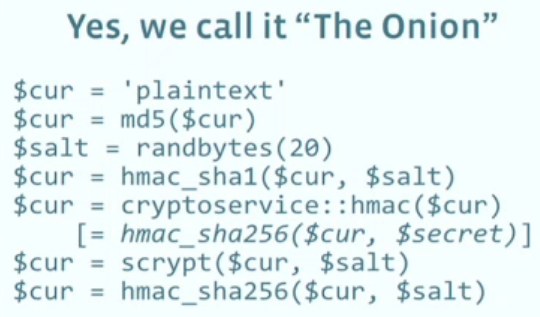

__Your task__: Implement the first 5 lines of the Facebook onion hash. Ignore the final 2 lines.

That is, write a function that does the following transformation to any password: apply `MD5`, take that result and apply `HMAC-SHA1` with a provided salt, and finally take that result and apply `HMAC-SHA256` with the same salt. Make sure that you pass along the results from one
to the other as binary bitstrings. The final result must be hex-encoded though so that it is safe to store in a database.

Use the salt as the secret key portion of the HMAC. You may find the following documentation useful when implementing HMAC: https://pycryptodome.readthedocs.io/en/latest/src/hash/hmac.html

Note: the purpose of the "salts" is to stop an attacker from pre-computing the hash of all likely passwords. The salt is generated randomly and independently for each user in the system. It is publicly posted next to the hashed password so a user can re-derive exactly the same hash on her next login. Since the salt is stored within the hashed password file, it is also stolen by any adversary who compromises the Facebook login servers. Nevertheless, at least the salts prevent simple frequency attacks: for instance, everyone who chooses the password password doesn’t have the same hash anymore. Instead, the attacker must attempt a separate brute-force password search for each user.

_Points:_ 1

In [11]:
from binascii import hexlify, unhexlify
from Crypto.Hash import HMAC, MD5, SHA, SHA256

def q3_onion_hash(password: bytes, salt: bytes) -> bytes:
    md5 = MD5.new(password).digest()
    hmac_sha1 = HMAC.new(salt, md5, SHA).digest()
    hmac_sha256 = HMAC.new(salt, hmac_sha1, SHA256).digest()
    return hexlify(hmac_sha256)

In [12]:
grader.check("q3")

q3 results: All test cases passed!

## Submitting the Assignment

Please follow these instructions to complete the assignment and submit it for credit.

**Documenting collaborators, sources, and AI tools:** In accordance with the collaboration policy, use the space below to report if you used any resources to complete this homework assignment, aside from the lecture notes and the course textbooks/videos. Specifically, please report:

1. Names of all classmates you worked with, and a short description of the work that you performed together.
2. All written materials that you used, such as books or websites (besides the lecture notes or textbooks). Please include links to any web-based resources, or citations to any physical works.
3. All code that you used from other sources. In particular, if you used an AI tool, then you must include the entire exchange with the AI tool, as per the [CDS Generative AI Assistance Policy](https://www.bu.edu/cds-faculty/culture-community/gaia-policy/).

Remember that if we discover any undocumented collaborators, sources, or AI tools then this is grounds for a grade penalty and referral to BU's Academic Conduct Committee (as described in the syllabus).

_Your response:_

1. N/A.

2. N/A.

3. N/A.

**Sending to Gradescope:** After completing the assignment:
- if you did the assignment on Colab, download it in `.ipynb` format.
- if you did the assignment locally on your machine, all you need to do is to find it in your directory.

Then, submit only the `.ipynb` file to this week's programming assignment on Gradescope. It may take a few seconds or a minute for the auto-grading system to check your work.

Remember that you can submit as many times as you want until the deadline for the assignment; only your last score counts.